In [12]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display
import numpy as np

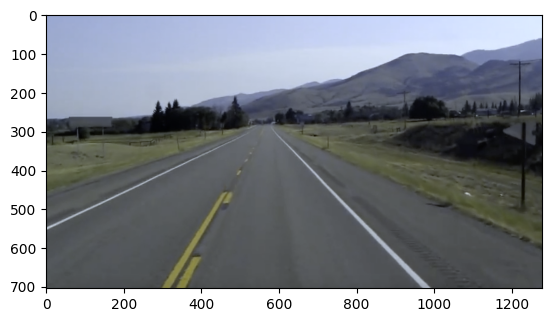

In [13]:
image =cv2.cvtColor(cv2.imread("/kaggle/input/roadlane/test_image.jpg"), cv2.COLOR_BGR2XYZ) 
plt.imshow(image)
plt.show()

In [14]:
lane_image = np.copy(image)
lane_image.shape

(704, 1279, 3)

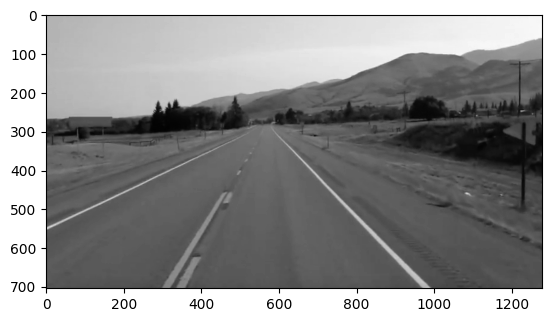

In [16]:
# Grayscale conversion of image
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray,cmap='gray')
plt.show()

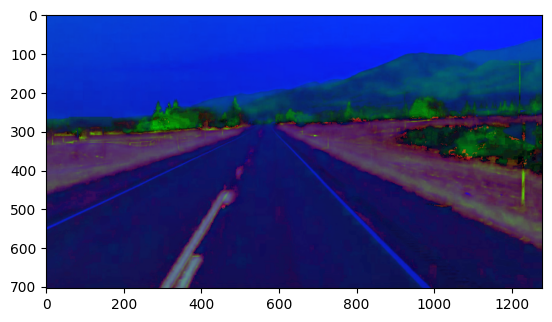

In [17]:
# Convert BGR to HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_image)
plt.show()

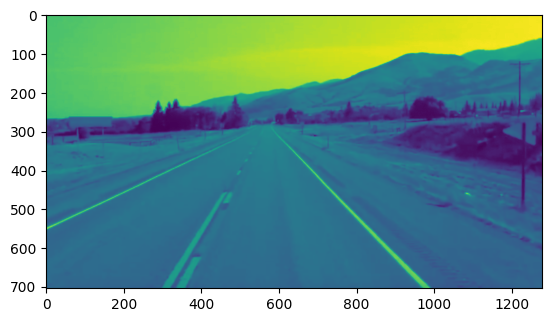

In [20]:
# Gausion blur to reduce noise
blur = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(blur)
plt.show()

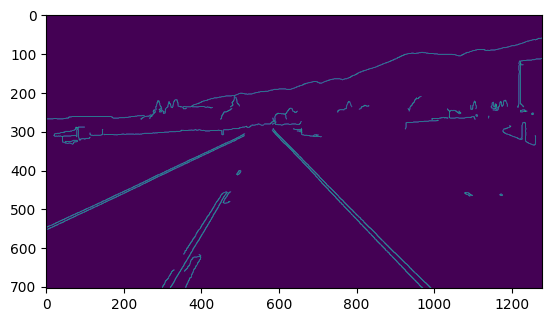

In [21]:
#canny method
canny = cv2.Canny(blur, 50,150)
plt.imshow(canny)
plt.show()

In [23]:
# All previous steps in one
def Canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

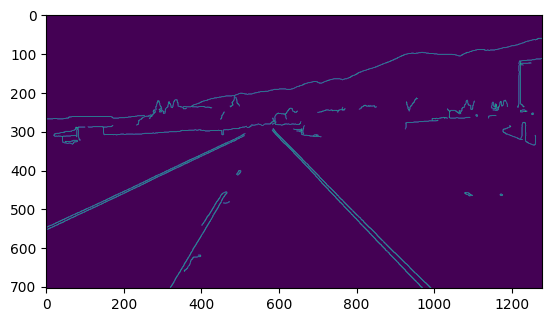

In [24]:
image = cv2.imread("/kaggle/input/roadlane/test_image.jpg")
lane_image = np.copy(image)
canny = Canny(lane_image)
plt.imshow(canny)
plt.show()

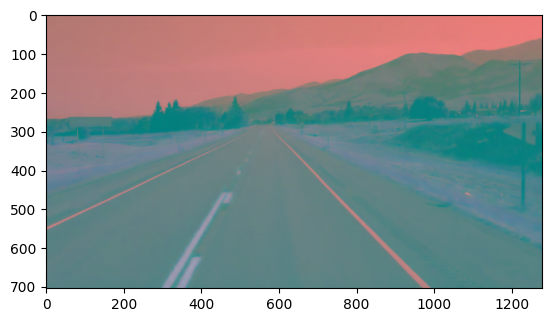

In [25]:
# Convert BGR to LAB
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
plt.imshow(lab_image)
plt.show()

In [26]:
# A function to find region of interest 
# Apply bitwise, operation to select region of interest

def region_of_interest(image):
    height = 700
    polygons = np.array([[(250,height), (1000,height), (600,250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_region = cv2.bitwise_and(image, mask)
    return masked_region

In [27]:
# Function which draws lines as detected lanes in the black image

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10)
    return line_image

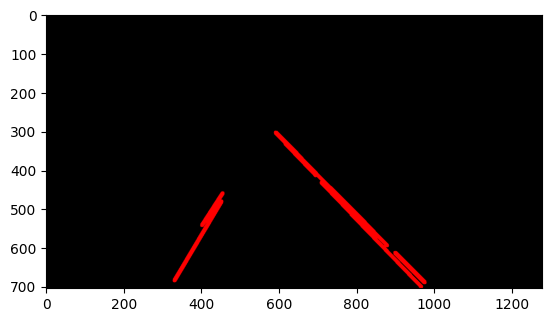

In [28]:
# Reading the image, calling all the functions one by one

image = cv2.imread("/kaggle/input/roadlane/test_image.jpg")

lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
line_image = display_lines(lane_image, lines)

plt.imshow(line_image)
plt.show()

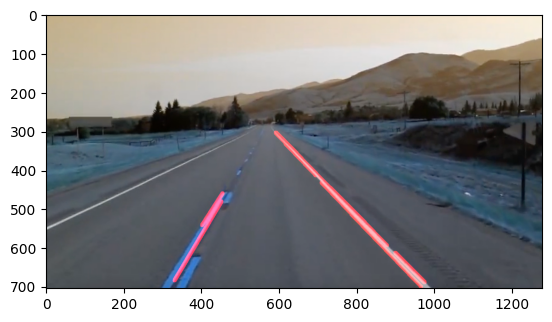

In [29]:
# final step: put it all together
# now combine the above immage containing just the lines in a black image with our original image
combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

plt.imshow(combo_image)
plt.show()

In [30]:
# Some optimization, refine the detection of lanes

def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

In [31]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1,x2), (y1,y2), 1)
        
        slope = parameters[0]
        intercept = parameters[1]
        
        if slope < 0:
            left_fit.append((slope, intercept))
        elif slope >= 0:
            right_fit.append((slope, intercept))
            
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
        
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
        
    return np.array([left_line, right_line])

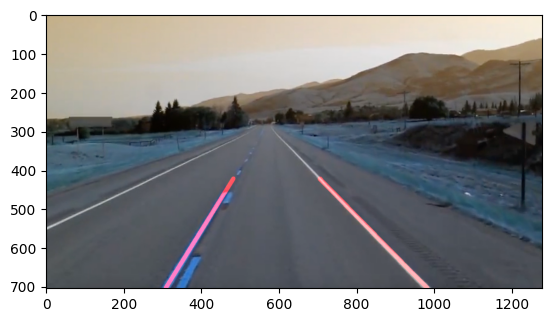

In [32]:
image = cv2.imread("/kaggle/input/roadlane/test_image.jpg")

lane_image = np.copy(image)
canny_image = Canny(lane_image)
cropped_image = region_of_interest(canny_image)

lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), 40, 5)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)

combo_image = cv2.addWeighted(lane_image, 1, line_image, 1, 1)

plt.imshow(combo_image)
plt.show()